In [75]:
# @title Data Generation
#A small dataset of dummy products was created with attributes such as name, description, price, and category. The dataset included 100 samples across five categories: Electronics, Clothing, Home Decor, Books, and Sports.
import pandas as pd
import numpy as np
import random

# Seed for reproducibility
np.random.seed(42)

# Categories and their specific keywords
category_keywords = {
    'Electronics': ['battery life', 'screen size', 'processor', 'touchscreen'],
    'Clothing': ['fabric type', 'care instructions', 'size', 'color options'],
    'Home Decor': ['material', 'dimensions', 'indoor/outdoor', 'style'],
    'Books': ['author', 'genre', 'number of pages', 'publisher'],
    'Sports': ['sport type', 'equipment type', 'material', 'recommended use']
}

# Generate descriptions
def generate_description(category):
    keywords = category_keywords[category]
    base_description = f"This {category} product has excellent features like {random.choice(keywords)} and {random.choice(keywords)}."
    return base_description

# Number of samples
num_samples = 100
categories = list(category_keywords.keys())

data = {
    'name': [f'Product {i}' for i in range(num_samples)],
    'description': [generate_description(random.choice(categories)) for i in range(num_samples)],
    'price': np.random.rand(num_samples) * 100,  # Random prices between 0 and 100
    'category': [random.choice(categories) for i in range(num_samples)]
}

# Creating DataFrame
df = pd.DataFrame(data)
df.to_csv('dummy_products.csv', index=False)
print("Data saved to 'dummy_products.csv'")



Data saved to 'dummy_products.csv'


In [76]:
# @title Data Preprocessing
#Text attributes were tokenized using the BERT tokenizer, and categorical attributes were encoded.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import tensorflow as tf

# Load the data
df = pd.read_csv('dummy_products.csv')

# Encode descriptions using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_descriptions(descriptions):
    return tokenizer(
        descriptions.tolist(),
        add_special_tokens=True,
        max_length=64,  # Increased max_length for better context understanding
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

encoded_data = encode_descriptions(df['description'])
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Encode categories
category_labels = df['category'].factorize()[0]

# Convert TensorFlow tensors to NumPy arrays
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()
category_labels = np.array(category_labels)

# Split the data
X_train, X_val, y_train, y_val, train_masks, val_masks = train_test_split(
    input_ids, category_labels, attention_masks, test_size=0.2, random_state=42
)


In [78]:
!pip install transformers tensorflow


In [83]:
# @title Model Implementation
#A BERT-based text classification model was developed using TensorFlow and trained on the generated dataset. The model's performance was evaluated using basic evaluation metrics.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
import tensorflow as tf

# Load the data
df = pd.read_csv('dummy_products.csv')

# Encode descriptions using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_descriptions(descriptions):
    return tokenizer(
        descriptions.tolist(),
        add_special_tokens=True,
        max_length=64,  # Increased max_length for better context understanding
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

encoded_data = encode_descriptions(df['description'])
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Encode categories
category_labels = df['category'].factorize()[0]

# Convert TensorFlow tensors to NumPy arrays
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()
category_labels = np.array(category_labels)

# Split the data
X_train, X_val, y_train, y_val, train_masks, val_masks = train_test_split(
    input_ids, category_labels, attention_masks, test_size=0.2, random_state=42
)

# Load BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category'].unique()))

# Define the optimizer
optimizer = AdamWeightDecay(learning_rate=2e-5, epsilon=1e-8)

# Compile the model
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    {'input_ids': X_train, 'attention_mask': train_masks}, y_train,
    validation_data=({'input_ids': X_val, 'attention_mask': val_masks}, y_val),
    epochs=10,
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate({'input_ids': X_val, 'attention_mask': val_masks}, y_val)
print(f'Validation Accuracy: {accuracy}')


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
10/10 [==============================] - 195s 10s/step - loss: 1.6535 - accuracy: 0.1500 - val_loss: 1.5875 - val_accuracy: 0.2000
Epoch 2/10
10/10 [==============================] - 85s 9s/step - loss: 1.6513 - accuracy: 0.2625 - val_loss: 1.6183 - val_accuracy: 0.1500
Epoch 3/10
10/10 [==============================] - 83s 9s/step - loss: 1.5649 - accuracy: 0.3125 - val_loss: 1.7322 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 1.5875 - accuracy: 0.2000
Validation Accuracy: 0.20000000298023224


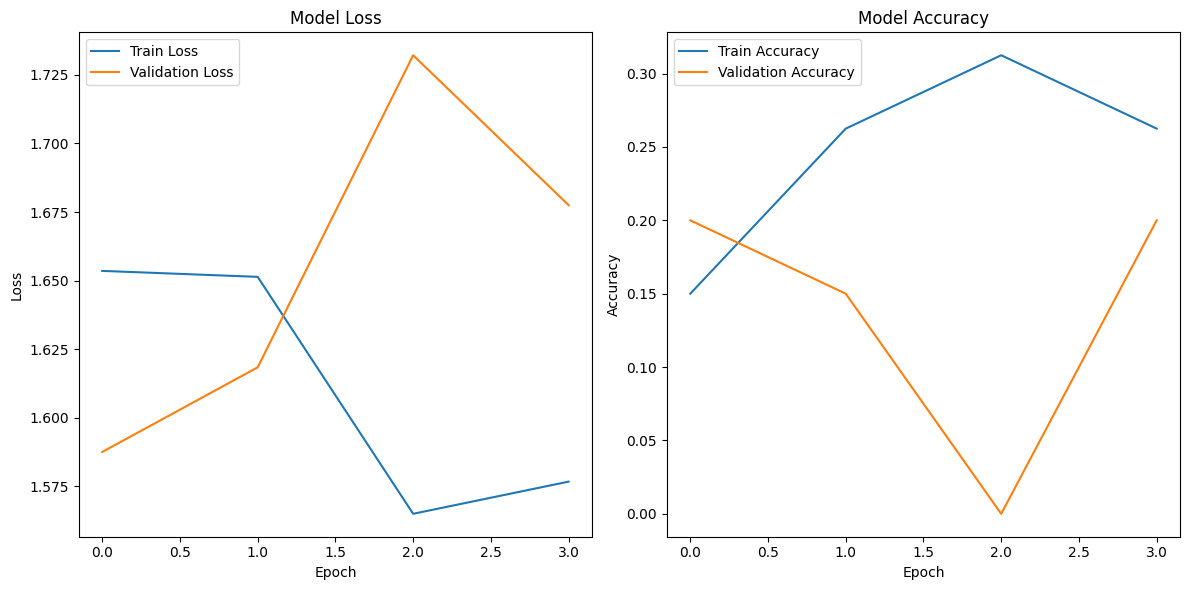

In [84]:
# Visualization of the training process
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()